REGRESSOR CNN

In [1]:
import os
import tensorflow as tf

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Configurazione manuale (più sicura)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("MEmory Growth attivata su GPU")
    except RuntimeError as e:
        print(e)

        
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_absolute_error
import gc

try:
    tf.config.experimental.enable_op_determinism()
    print("Op Determinism Abilitato!")
except AttributeError:
    print("Attenzione: La tua versione di TF è troppo vecchia per enable_op_determinism.")

def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
SEEDS = [7,42,555]

I0000 00:00:1765799078.757940  390900 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765799078.789210  390900 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765799079.386285  390900 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


MEmory Growth attivata su GPU
2.21.0-dev20251210
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Op Determinism Abilitato!


W0000 00:00:1765799080.132016  390900 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


DATASET LOADING

In [2]:
def load_dataset():
    folder='dataset/images'
    data=[]
    for filename in sorted(os.listdir(folder)):   
        img_path=os.path.join(folder,filename)
        img=cv2.imread(img_path) #opencv save in bgr
        data.append({
            'image':img,
            'filename':filename
        })

    data_map = {item['filename']: item['image'] for item in data}
    label=pd.read_csv('dataset/raw/bbx_annotations.csv')
    #just to avoid warning
    coords = ['xmin', 'xmax', 'ymin', 'ymax']
    label[coords] = label[coords].astype(float)
    
    upper_mask = label['filename'].str.lower().str.contains('upper')
    label.loc[upper_mask, ['xmin', 'xmax', 'ymin', 'ymax']] /= 2
    
    for i,item in enumerate(data):
        if "upper" in item["filename"].lower():
            data[i]['image']=cv2.resize(
                data[i]['image'],
                (data[i]['image'].shape[1]//2,data[i]['image'].shape[0]//2)
                ,interpolation=cv2.INTER_AREA
            )
    return data, label

DATA MODELLING
train df will be: image--> w1, h1, w2,h2....w9,h9
where:w1 width of mean point of the bbox closer to x=0. if w9/h9 doesnt exist=-1 

In [3]:
def dataset_modelling(data,annotation):
    dataset_df = pd.DataFrame(data) 

    
    grouped = annotation.groupby('filename').agg(list).reset_index()
    merged = pd.merge(dataset_df, grouped, on='filename')
    MAX_OBJECTS = 9
    target_vectors = [] 
    class_vectors = []
    label_map={'goalpost':1,
               'ball':2,
               'robot':3,
               'goalspot':4,
               'centerspot':5}
    
    for i,row in merged.iterrows():
        temp_objects = []
        for j in range(len(row['xmin'])):
            xmin, xmax = row['xmin'][j], row['xmax'][j]
            ymin, ymax = row['ymin'][j], row['ymax'][j]
            cls_str = row['class'][j]
            cx = (xmin + xmax) / 2.0 / 320.0 
            cy = (ymin + ymax) / 2.0 / 240.0
            cls_id = label_map.get(cls_str, 0)
            temp_objects.append((cx, cy, cls_id))

        temp_objects.sort(key=lambda x: x[0])
        flat_target = []
        flat_class = []
        
        for obj in temp_objects:
            flat_target.extend([obj[0], obj[1]]) 
            flat_class.append(obj[2])

        target_len = MAX_OBJECTS * 2
        if len(flat_target) < target_len:
            flat_target.extend([0.0] * (target_len - len(flat_target)))
        elif len(flat_target) > target_len: #shouldnt happen
            flat_target = flat_target[:target_len]

        if len(flat_class) < MAX_OBJECTS:
            flat_class.extend([0] * (MAX_OBJECTS - len(flat_class)))
        elif len(flat_class) > MAX_OBJECTS:
            flat_class = flat_class[:MAX_OBJECTS]

        target_vectors.append(np.array(flat_target, dtype='float32'))
        class_vectors.append(np.array(flat_class, dtype='int32'))
    merged['target_vec'] = target_vectors
    merged['class_vec'] = class_vectors    


    train_df, test_df = train_test_split(merged, test_size=0.2, random_state=42)

    x_train_img = np.array(train_df['image'].tolist()).astype('float32') / 255.0
    x_train_class=np.array(train_df['class_vec'].tolist()).astype('float32')
    y_train = np.array(train_df['target_vec'].tolist()).astype('float32')

    x_test_img = np.array(test_df['image'].tolist()).astype('float32') / 255.0
    x_test_class= np.array(test_df['class_vec'].tolist()).astype('float32')
    y_test = np.array(test_df['target_vec'].tolist()).astype('float32')

    return x_train_img,x_train_class,y_train,x_test_img,x_test_class,y_test

PARAMETER SEARCH

In [ ]:
def create_hyperparam_combination():
    param_grid = {
    'batch_size': [16],
    'layer_number':[5],
    'kernel_dim': [7],
    'pool_dim': [3], 
    'lr': [0.0001],
    'fc1' : [512],
    'fc2': [256],
    'class_out':[16,32,64,128],
    'activation':['relu','elu'],
    'dropout':[0.1,0.2]
      
}

    #every possible combination
    keys, values = zip(*param_grid.items())
    combinations = list(itertools.product(*values))
    combinations_dicts = [dict(zip(keys, v)) for v in combinations]
    return combinations_dicts

BUILDING MODEL

In [ ]:
def build_model(layer_num,kernel_dim,pool_dim,fc1,fc2,activation,clas_out,drop):
    input_img = Input(shape=(240, 320, 3), name='input_image')
    x = input_img
    filters = 16
    for i in range(layer_num):
        x = layers.Conv2D(filters, (kernel_dim, kernel_dim), activation=activation, padding='same')(x)
        x = layers.AveragePooling2D((pool_dim,pool_dim),strides=2,padding='same')(x)
        x = layers.Dropout(drop)(x)

        filters = min(filters * 2, 512)
    
    feat_img = layers.GlobalAveragePooling2D()(x) 
    input_classes = Input(shape=(9,), name='input_classes')
    y = layers.Embedding(input_dim=6, output_dim=clas_out)(input_classes)
    y = layers.Flatten()(y)

    combined = layers.Concatenate()([feat_img, y])
    z = layers.Dense(fc1, activation='relu')(combined)
    z = layers.Dense(fc2, activation='relu')(z)

    output = layers.Dense(18, activation='sigmoid')(z)
    model = models.Model(inputs=[input_img, input_classes], outputs=output)
    
   

    #model.summary()
    return model

SAVE CSV

In [6]:
def save_csv(mae,param,seed,all_results,r2):
    current_result = param.copy()  
    current_result['mae_Score']=mae
    current_result['R2_Score']=r2


    all_results.append(current_result)

    pd.DataFrame(all_results).to_csv(f'regression/csv/search/multi_input_mae_{seed}.csv', index=False)

VISUALIZING DATA

In [7]:

def visualize_only_centers(model, x_test, y_test,seed):
    index_list=[1,12,21,34,25,46,14,19,40]
    for index in index_list:
        img_norm = x_test[0][index].copy()  
        input_class = x_test[1][index]      
        
        real_targets = y_test[index]
        
        sample_img_batch = x_test[0][index:index+1]
        sample_cls_batch = x_test[1][index:index+1]
        
        pred_targets = model.predict([sample_img_batch, sample_cls_batch], verbose=0)[0]
        
        if img_norm.max() <= 1.0:
            img_display = (img_norm * 255).astype(np.uint8)
        else:
            img_display = img_norm.astype(np.uint8)
            
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
        
        IMG_H, IMG_W = img_display.shape[:2]
        
        print(f"\n--- Analisi Centri Immagine {index} ---")

        def draw_points(targets, color, label):
            for i in range(0, len(targets), 2):
                if i+1 >= len(targets): break
                
                xc = targets[i]
                yc = targets[i+1]
                
                if xc < 0.01 and yc < 0.01: continue
                
                xc_px = int(xc * IMG_W)
                yc_px = int(yc * IMG_H)
                
                cv2.circle(img_display, (xc_px, yc_px), 3, color, -1)
                
                cv2.circle(img_display, (xc_px, yc_px), 5, (255, 255, 255), 1)
                
                print(f"{label} {i//2+1}: ({xc_px}, {yc_px}) px")

        draw_points(real_targets, (0, 255, 0), "Reale")    # Verde
        draw_points(pred_targets, (255, 0, 0), "Predetto") # Rosso

        plt.figure(figsize=(6,6))
        plt.imshow(img_display)
        plt.title(f"Img {index}: green=REAL  red=PREDICTION")
        plt.axis('off')
        
        save_path=f'regression/images/predvstrue/img{index}_seed{seed}'
        
        plt.savefig(save_path, bbox_inches='tight') 
        
        plt.show()
        plt.close()

MAIN


 ================== INIZIO CICLO CON SEED: 7 ================== 
ITERAZIONE 1 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 256, 'fc2': 256}


W0000 00:00:1765799082.150785  390900 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1765799082.231866  390900 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9252 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


Epoch 1/120


I0000 00:00:1765799083.868520  391067 cuda_dnn.cc:461] Loaded cuDNN version 91600


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.1702 - mse: 0.0787 - val_loss: 0.0961 - val_mse: 0.0474
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0976 - mse: 0.0488 - val_loss: 0.0954 - val_mse: 0.0483
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0966 - mse: 0.0486 - val_loss: 0.0919 - val_mse: 0.0466
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0924 - mse: 0.0459 - val_loss: 0.0870 - val_mse: 0.0427
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0875 - mse: 0.0429 - val_loss: 0.0851 - val_mse: 0.0425
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0850 - mse: 0.0418 - val_loss: 0.0821 - val_mse: 0.0411
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0833 - mse: 0.0410 - val_loss: 0.0806 - val_mse: 0.0405
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0820 - mse: 0.0404 - val_loss: 0.0795 - val_mse: 0.0400
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0808 -

E0000 00:00:1765799508.753776  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.0247346218675375

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.05401778 0.23992047 0.22636454 0.17418861]
ITERAZIONE 2 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1758 - mse: 0.0819 - val_loss: 0.0956 - val_mse: 0.0511
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0988 - mse: 0.0531 - val_loss: 0.0957 - val_mse: 0.0511
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0982 - mse: 0.0525 - val_loss: 0.0954 - val_mse: 0.0510
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0959 - mse: 0.0488 - val_loss: 0.0899 - val_mse: 0.0467
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0910 - mse: 0.0458 - val_loss: 0.0862 - val_mse

E0000 00:00:1765799932.978702  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.02460688166320324

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.09193023 0.22712378 0.28129306 0.15937531]
ITERAZIONE 3 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1398 - mse: 0.0848 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse

E0000 00:00:1765799991.768215  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.13414011895656586

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1. 0. 0. 0.]
ITERAZIONE 4 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1420 - mse: 0.0852 - val_loss: 0.1288 - val_mse: 0.0821
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1305 - mse: 0.0822 - val_loss: 0.1288 - val_mse: 0.0821
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1305 - mse: 0.0822 - val_loss: 0.1288 - val_mse: 0.0821
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1305 - mse: 0.0822 - val_loss: 0.1288 - val_mse: 0.0821
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1305 - mse: 0.0822 - val_loss: 0.1288 - val_mse: 0.0821
Epoch 6/120
88/88 ━━━━━

E0000 00:00:1765800050.676534  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.1304824948310852

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0. 1. 0. 0.]
ITERAZIONE 5 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.4140 - mse: 0.1888 - val_loss: 0.3706 - val_mse: 0.1513
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2095 - mse: 0.0770 - val_loss: 0.1091 - val_mse: 0.0508
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1016 - mse: 0.0480 - val_loss: 0.0967 - val_mse: 0.0459
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0979 - mse: 0.0474 - val_loss: 0.0958 - val_mse: 0.0458
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0974 - mse: 0.0474 - val_loss: 0.0955 - val_mse: 0.0456
Epoch 6/120
88/88 ━━━━━━

E0000 00:00:1765800480.938085  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.07403711974620819

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.17722085 0.1705641  0.4774676  0.17864035]
ITERAZIONE 6 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.4180 - mse: 0.1924 - val_loss: 0.3896 - val_mse: 0.1666
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2210 - mse: 0.0819 - val_loss: 0.1037 - val_mse: 0.0465
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1003 - mse: 0.0479 - val_loss: 0.0966 - val_mse: 0.0464
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0980 - mse: 0.0475 - val_loss: 0.0959 - val_mse: 0.0457
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0974 - mse: 0.0473 - val_loss: 0.0953 - val_mse

E0000 00:00:1765800911.384415  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.07136966288089752

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.19547448 0.17856868 0.40883973 0.1518906 ]
ITERAZIONE 7 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2740 - mse: 0.1165 - val_loss: 0.0958 - val_mse: 0.0470
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0969 - mse: 0.0484 - val_loss: 0.0939 - val_mse: 0.0465
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0957 - mse: 0.0478 - val_loss: 0.0932 - val_mse: 0.0462
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0939 - mse: 0.0463 - val_loss: 0.0906 - val_mse: 0.0438
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0909 - mse: 0.0444 - val_loss: 0.0877 - val_ms

E0000 00:00:1765801025.641257  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.032881975173950195

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.12809804 0.19226752 0.26592195 0.135418  ]
ITERAZIONE 8 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2567 - mse: 0.1091 - val_loss: 0.0953 - val_mse: 0.0487
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0965 - mse: 0.0485 - val_loss: 0.0935 - val_mse: 0.0466
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0948 - mse: 0.0474 - val_loss: 0.0916 - val_mse: 0.0457
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0929 - mse: 0.0466 - val_loss: 0.0897 - val_mse: 0.0451
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0912 - mse: 0.0459 - val_loss: 0.0882 - val_m

E0000 00:00:1765801136.824431  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.03265289217233658

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.15634184 0.17963229 0.2786201  0.15370266]
ITERAZIONE 9 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1396 - mse: 0.0739 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1231 - mse: 0.0749 - val_loss: 0.1288 - val_mse: 0.0821
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1305 - mse: 0.0822 - val_loss: 0.1288 - val_mse

E0000 00:00:1765801155.398503  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.11722885072231293

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1.3562680e-23 4.9756386e-06 1.7338040e-07 6.7898173e-23]
ITERAZIONE 10 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1372 - mse: 0.0732 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1

E0000 00:00:1765801171.985257  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.11722898483276367

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1.3325825e-19 9.9781006e-10 2.3696519e-23 4.7516639e-22]
ITERAZIONE 11 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4265 - mse: 0.2003 - val_loss: 0.4247 - val_mse: 0.1986
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4169 - mse: 0.1910 - val_loss: 0.4087 - val_mse: 0.1834
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3830 - mse: 0.1613 - val_loss: 0.3477 - val_mse: 0.1332
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2769 - mse: 0.0920 - val_loss: 0.2025 - val_mse: 0.0589
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1507 - mse: 0.0492 - val_loss: 0.1

E0000 00:00:1765801284.526422  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.0737459808588028

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.18218122 0.1724863  0.44117963 0.16905303]
ITERAZIONE 12 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4246 - mse: 0.1985 - val_loss: 0.4219 - val_mse: 0.1959
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4121 - mse: 0.1866 - val_loss: 0.4001 - val_mse: 0.1755
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3627 - mse: 0.1450 - val_loss: 0.3079 - val_mse: 0.1053
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2223 - mse: 0.0667 - val_loss: 0.1519 - val_mse: 0.0465
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1241 - mse: 0.0457 - val_loss: 0.1086 - val_mse

E0000 00:00:1765801398.431321  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.06420490890741348

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.14609285 0.18295848 0.41199934 0.16431297]
ITERAZIONE 13 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1481 - mse: 0.0717 - val_loss: 0.0980 - val_mse: 0.0544
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0992 - mse: 0.0534 - val_loss: 0.0953 - val_mse: 0.0509
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0984 - mse: 0.0528 - val_loss: 0.0946 - val_mse: 0.0506
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0961 - mse: 0.0503 - val_loss: 0.0883 - val_mse: 0.0437
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0896 - mse: 0.0438 - val_loss: 0.0841 - val_m

E0000 00:00:1765801794.494597  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.023474210873246193

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.04512699 0.2104961  0.17007208 0.18155123]
ITERAZIONE 14 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1447 - mse: 0.0700 - val_loss: 0.0959 - val_mse: 0.0522
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0986 - mse: 0.0520 - val_loss: 0.0950 - val_mse: 0.0501
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0961 - mse: 0.0487 - val_loss: 0.0906 - val_mse: 0.0454
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0908 - mse: 0.0453 - val_loss: 0.0850 - val_mse: 0.0425
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0859 - mse: 0.0420 - val_loss: 0.0820 - val_

E0000 00:00:1765802254.677274  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.0219514649361372

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0255368  0.19478463 0.15572268 0.19763519]
ITERAZIONE 15 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1393 - mse: 0.0852 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse

E0000 00:00:1765802317.006430  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.13414011895656586

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1. 0. 0. 0.]
ITERAZIONE 16 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1378 - mse: 0.0842 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 6/120
88/88 ━━━━

E0000 00:00:1765802379.613545  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.13414011895656586

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1. 0. 0. 0.]
ITERAZIONE 17 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.3673 - mse: 0.1587 - val_loss: 0.1744 - val_mse: 0.0657
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1083 - mse: 0.0497 - val_loss: 0.0957 - val_mse: 0.0461
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0975 - mse: 0.0479 - val_loss: 0.0952 - val_mse: 0.0466
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0973 - mse: 0.0478 - val_loss: 0.0949 - val_mse: 0.0458
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0969 - mse: 0.0475 - val_loss: 0.0947 - val_mse: 0.0457
Epoch 6/120
88/88 ━━━━

E0000 00:00:1765802840.827735  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.07207468152046204

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.07491193 0.20660542 0.28818205 0.16719225]
ITERAZIONE 18 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.3546 - mse: 0.1509 - val_loss: 0.1427 - val_mse: 0.0498
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1036 - mse: 0.0487 - val_loss: 0.0955 - val_mse: 0.0470
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0977 - mse: 0.0488 - val_loss: 0.0950 - val_mse: 0.0469
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0973 - mse: 0.0487 - val_loss: 0.0947 - val_mse: 0.0469
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0971 - mse: 0.0486 - val_loss: 0.0945 - val_ms

E0000 00:00:1765803301.323218  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.06917126476764679

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0675653  0.2058085  0.2495783  0.15188499]
ITERAZIONE 19 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2183 - mse: 0.0967 - val_loss: 0.0957 - val_mse: 0.0504
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0974 - mse: 0.0493 - val_loss: 0.0941 - val_mse: 0.0469
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0960 - mse: 0.0482 - val_loss: 0.0930 - val_mse: 0.0467
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0941 - mse: 0.0472 - val_loss: 0.0899 - val_mse: 0.0455
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0901 - mse: 0.0454 - val_loss: 0.0851 - val_m

E0000 00:00:1765803422.495957  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.027771955356001854

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.05110628 0.1990607  0.188126   0.1611224 ]
ITERAZIONE 20 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2037 - mse: 0.0891 - val_loss: 0.0963 - val_mse: 0.0481
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0968 - mse: 0.0486 - val_loss: 0.0937 - val_mse: 0.0470
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0946 - mse: 0.0475 - val_loss: 0.0911 - val_mse: 0.0460
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0916 - mse: 0.0460 - val_loss: 0.0861 - val_mse: 0.0438
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0876 - mse: 0.0444 - val_loss: 0.0840 - val_

E0000 00:00:1765803543.493444  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 0.026454884558916092

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.05751954 0.1953343  0.17769976 0.1704    ]
ITERAZIONE 21 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1340 - mse: 0.0731 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_m

E0000 00:00:1765803561.120393  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.11722898483276367

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.000000e+00 0.000000e+00 3.557583e-22 0.000000e+00]
ITERAZIONE 22 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1523 - mse: 0.0932 - val_loss: 0.1422 - val_mse: 0.0955
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1455 - mse: 0.0972 - val_loss: 0.1422 - val_mse: 0.0955
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1455 - mse: 0.0972 - val_loss: 0.1422 - val_mse: 0.0955
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1455 - mse: 0.0972 - val_loss: 0.1422 - val_mse: 0.0955
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1455 - mse: 0.0972 - val_loss: 0.1422 

E0000 00:00:1765803578.982610  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.1473936289548874

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1. 1. 0. 0.]
ITERAZIONE 23 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4236 - mse: 0.1975 - val_loss: 0.4183 - val_mse: 0.1925
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3895 - mse: 0.1673 - val_loss: 0.3336 - val_mse: 0.1237
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2129 - mse: 0.0697 - val_loss: 0.1252 - val_mse: 0.0470
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1083 - mse: 0.0467 - val_loss: 0.0996 - val_mse: 0.0464
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0996 - mse: 0.0477 - val_loss: 0.0965 - val_mse: 0.0467
Epoch 6/120
88/88 ━━━━━

E0000 00:00:1765803698.699037  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.07365086674690247

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.16410324 0.18936564 0.4436541  0.18335985]
ITERAZIONE 24 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4215 - mse: 0.1954 - val_loss: 0.4127 - val_mse: 0.1872
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3667 - mse: 0.1498 - val_loss: 0.2824 - val_mse: 0.0925
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1714 - mse: 0.0547 - val_loss: 0.1128 - val_mse: 0.0449
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1044 - mse: 0.0461 - val_loss: 0.0985 - val_mse: 0.0460
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0988 - mse: 0.0473 - val_loss: 0.0961 - val_ms

E0000 00:00:1765803820.354974  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.07187224924564362

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.17801505 0.18696797 0.43274358 0.17466497]
{'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'seed': 7, 'best_mae_score': 0.0219514649361372, 'best_r2_score': 0.6981773376464844}

--- Analisi Centri Immagine 1 ---
Reale 1: (212, 49) px
Reale 2: (247, 26) px
Predetto 1: (110, 64) px
Predetto 2: (220, 48) px


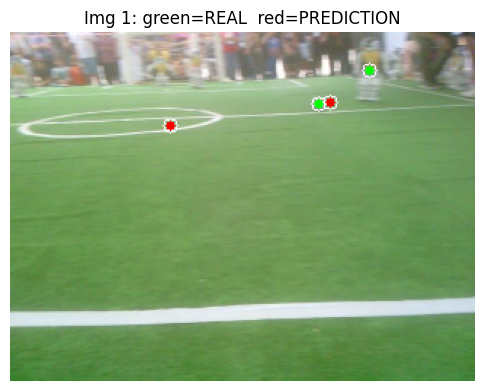


--- Analisi Centri Immagine 12 ---
Reale 1: (56, 21) px
Reale 2: (243, 50) px
Predetto 1: (87, 43) px
Predetto 2: (236, 50) px


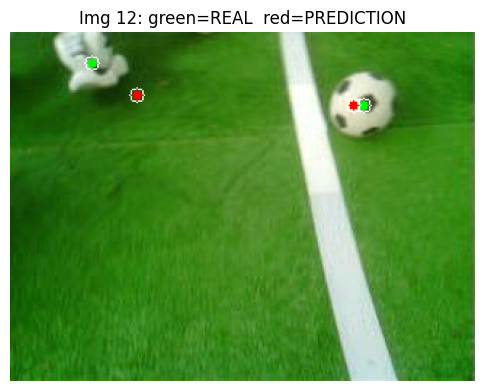


--- Analisi Centri Immagine 21 ---
Reale 1: (29, 182) px
Predetto 1: (180, 64) px


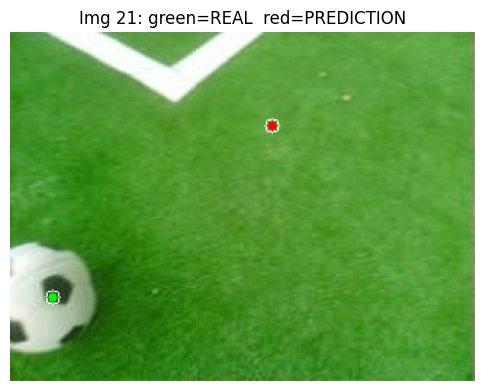


--- Analisi Centri Immagine 34 ---
Reale 1: (296, 107) px
Predetto 1: (162, 40) px


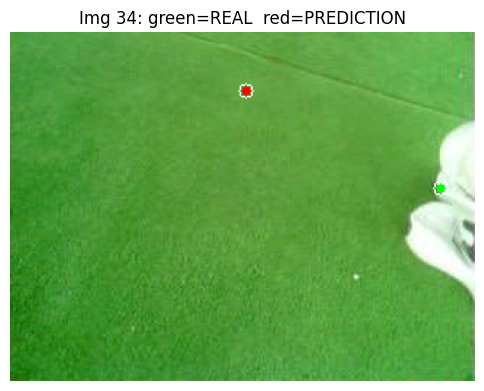


--- Analisi Centri Immagine 25 ---
Reale 1: (64, 39) px
Reale 2: (65, 63) px
Reale 3: (84, 28) px
Reale 4: (120, 33) px
Reale 5: (160, 26) px
Reale 6: (218, 42) px
Predetto 1: (65, 40) px
Predetto 2: (103, 45) px


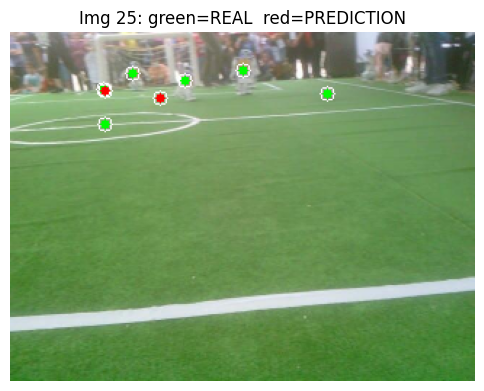


--- Analisi Centri Immagine 46 ---
Reale 1: (74, 148) px
Predetto 1: (158, 161) px
Predetto 2: (2, 4) px


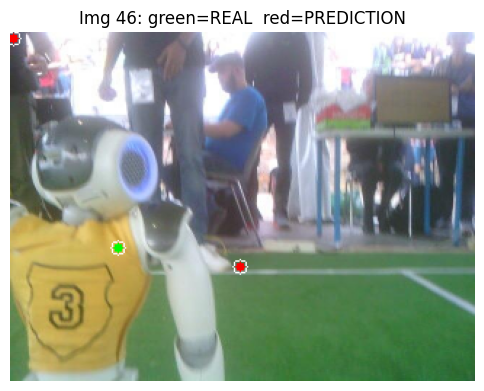


--- Analisi Centri Immagine 14 ---
Reale 1: (29, 52) px
Reale 2: (164, 22) px
Predetto 1: (97, 49) px
Predetto 2: (226, 52) px


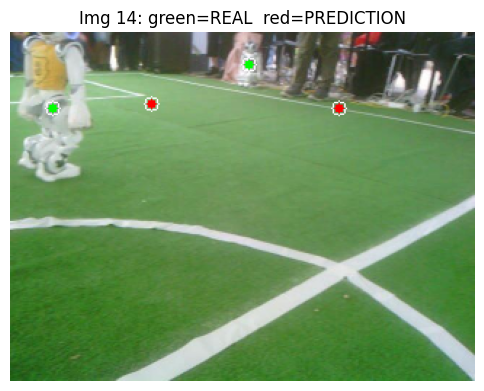


--- Analisi Centri Immagine 19 ---
Reale 1: (73, 178) px
Reale 2: (89, 186) px
Reale 3: (110, 188) px
Reale 4: (129, 180) px
Reale 5: (253, 229) px
Reale 6: (293, 197) px
Predetto 1: (33, 187) px
Predetto 2: (90, 183) px


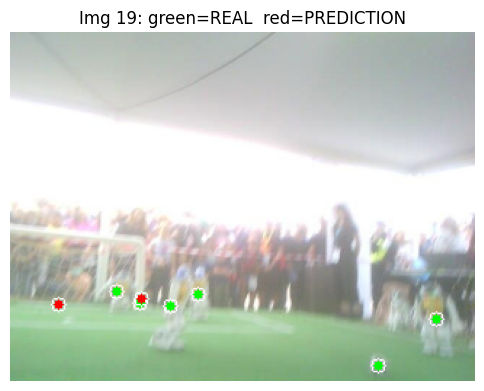


--- Analisi Centri Immagine 40 ---
Reale 1: (122, 66) px
Reale 2: (270, 49) px
Predetto 1: (97, 55) px
Predetto 2: (233, 58) px


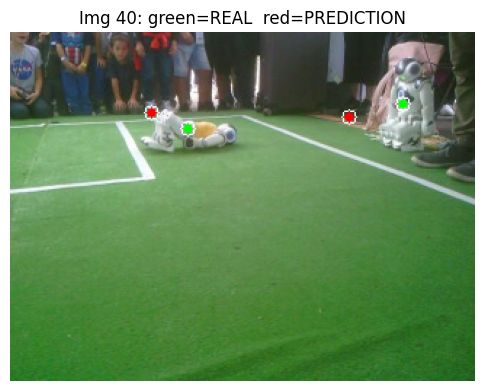


 ================== INIZIO CICLO CON SEED: 42 ================== 
ITERAZIONE 1 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1795 - mse: 0.0841 - val_loss: 0.0951 - val_mse: 0.0516
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0993 - mse: 0.0536 - val_loss: 0.0960 - val_mse: 0.0518
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0985 - mse: 0.0529 - val_loss: 0.0955 - val_mse: 0.0514
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0980 - mse: 0.0526 - val_loss: 0.0951 - val_mse: 0.0512
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0971 - mse: 0.0520 - val_loss: 0.0926 - val_mse: 0.0499
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0942 - mse: 0.0506 - val_loss: 0.0900 - val_mse: 0.0491
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0912 - mse: 0.046

E0000 00:00:1765804248.765818  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.02674218639731407

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.04791519 0.24116494 0.234915   0.18160746]
ITERAZIONE 2 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1763 - mse: 0.0829 - val_loss: 0.0964 - val_mse: 0.0534
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0995 - mse: 0.0536 - val_loss: 0.0963 - val_mse: 0.0520
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0985 - mse: 0.0526 - val_loss: 0.0958 - val_mse: 0.0503
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0964 - mse: 0.0478 - val_loss: 0.0932 - val_mse: 0.0452
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0911 - mse: 0.0442 - val_loss: 0.0846 - val_ms

E0000 00:00:1765804675.845111  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.025528237223625183

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.06146998 0.18832958 0.2550696  0.15082154]
ITERAZIONE 3 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1411 - mse: 0.0842 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_ms

E0000 00:00:1765804734.324657  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.13414011895656586

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1. 0. 0. 0.]
ITERAZIONE 4 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1265 - mse: 0.0708 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 6/120
88/88 ━━━━━

E0000 00:00:1765804792.936033  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.11722898483276367

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0. 0. 0. 0.]
ITERAZIONE 5 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.4184 - mse: 0.1924 - val_loss: 0.3910 - val_mse: 0.1672
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2429 - mse: 0.0898 - val_loss: 0.1226 - val_mse: 0.0524
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1041 - mse: 0.0496 - val_loss: 0.0968 - val_mse: 0.0489
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0977 - mse: 0.0485 - val_loss: 0.0959 - val_mse: 0.0486
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0971 - mse: 0.0484 - val_loss: 0.0956 - val_mse: 0.0485
Epoch 6/120
88/88 ━━━━━

E0000 00:00:1765805225.021514  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.07415587455034256

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.15035342 0.19503799 0.45755726 0.18610516]
ITERAZIONE 6 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.4174 - mse: 0.1915 - val_loss: 0.3842 - val_mse: 0.1617
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.2230 - mse: 0.0828 - val_loss: 0.1101 - val_mse: 0.0468
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1014 - mse: 0.0477 - val_loss: 0.0977 - val_mse: 0.0481
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0974 - mse: 0.0469 - val_loss: 0.0966 - val_mse: 0.0473
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0967 - mse: 0.0467 - val_loss: 0.0959 - val_mse

E0000 00:00:1765805654.948598  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.07163450121879578

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.13068065 0.19738051 0.3720783  0.16519573]
ITERAZIONE 7 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2879 - mse: 0.1221 - val_loss: 0.0971 - val_mse: 0.0504
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0982 - mse: 0.0506 - val_loss: 0.0965 - val_mse: 0.0493
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0963 - mse: 0.0478 - val_loss: 0.0948 - val_mse: 0.0474
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0940 - mse: 0.0455 - val_loss: 0.0919 - val_mse: 0.0450
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0907 - mse: 0.0438 - val_loss: 0.0878 - val_ms

E0000 00:00:1765805769.733961  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.03266582265496254

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.09346735 0.1658274  0.22328033 0.14393784]
ITERAZIONE 8 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2704 - mse: 0.1142 - val_loss: 0.0960 - val_mse: 0.0492
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0962 - mse: 0.0477 - val_loss: 0.0943 - val_mse: 0.0460
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0931 - mse: 0.0451 - val_loss: 0.0912 - val_mse: 0.0446
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0900 - mse: 0.0438 - val_loss: 0.0881 - val_mse: 0.0423
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0875 - mse: 0.0427 - val_loss: 0.0849 - val_ms

E0000 00:00:1765805886.356258  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.032162055373191833

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.08753701 0.15630567 0.22534384 0.14487296]
ITERAZIONE 9 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.001, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1516 - mse: 0.0841 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_mse: 0.0797
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1303 - mse: 0.0821 - val_loss: 0.1264 - val_ms

E0000 00:00:1765805903.250095  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 0.13414011895656586

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [1.0000000e+00 3.8374977e-14 3.7369879e-10 5.8415375e-18]
ITERAZIONE 10 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 0.001, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1320 - mse: 0.0682 - val_loss: 0.0967 - val_mse: 0.0523
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0787 - mse: 0.0333 - val_loss: 0.0549 - val_mse: 0.0160
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0538 - mse: 0.0161 - val_loss: 0.0498 - val_mse: 0.0144
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0505 - mse: 0.0147 - val_loss: 0.0471 - val_mse: 0.0140
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0438 - mse: 0.0116 - val_loss: 0.0

E0000 00:00:1765805942.952228  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.03299694135785103

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.06401394 0.14140415 0.1734629  0.15182427]
ITERAZIONE 11 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 256, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4262 - mse: 0.1999 - val_loss: 0.4248 - val_mse: 0.1986
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4188 - mse: 0.1927 - val_loss: 0.4140 - val_mse: 0.1881
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3970 - mse: 0.1725 - val_loss: 0.3723 - val_mse: 0.1511
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3081 - mse: 0.1075 - val_loss: 0.2283 - val_mse: 0.0651
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1643 - mse: 0.0490 - val_loss: 0.1260 - val_ms

E0000 00:00:1765806057.530033  390900 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.0727011039853096

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.15878636 0.16054209 0.35514793 0.14771497]
ITERAZIONE 12 of 24
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 4, 'kernel_dim': 3, 'pool_dim': 3, 'lr': 1e-05, 'fc1': 512, 'fc2': 256}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4259 - mse: 0.1996 - val_loss: 0.4236 - val_mse: 0.1974
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4150 - mse: 0.1891 - val_loss: 0.4061 - val_mse: 0.1808
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3787 - mse: 0.1572 - val_loss: 0.3379 - val_mse: 0.1251
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2546 - mse: 0.0799 - val_loss: 0.1732 - val_mse: 0.0491
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1327 - mse: 0.0438 - val_loss: 0.1110 - val_mse

In [ ]:
ddata,annotation=load_dataset()
x_train_img,x_train_class,y_train,x_test_img,x_test_class,y_test=dataset_modelling(data,annotation)
combination=create_hyperparam_combination()
total_combinations = len(combination)
x_train=[x_train_img,x_train_class]
x_test=[x_test_img,x_test_class]

final_results = []
for seed in SEEDS:
    print(f"\n ================== INIZIO CICLO CON SEED: {seed} ================== ")
    all_results = []
    bestmae=100000
    best_r2=-1000000
    current_seed_best_params = {}
    for i,param in enumerate(combination):
        print(f"ITERAZIONE {i+1} of {total_combinations}")
        print(f"PARAMETRI ATTUALI: {param}")     
        tf.keras.backend.clear_session()
        gc.collect()
        reset_seeds(seed)

        model=build_model( param['layer_number'],param['kernel_dim'],param['pool_dim'],param['fc1'],param['fc2'],param['activation'],param['class_out'],param['dropout'])

        opt=tf.keras.optimizers.Adam(learning_rate=param['lr'])

        model.compile(optimizer=opt,
                        loss='mae',
                        metrics=['mse'])
        
        early_stop=EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
            )
        
        reset_seeds(seed)
        history=model.fit(
                x_train,y_train,
                epochs=120,
                batch_size=param['batch_size'], 
                validation_split=0.2, 
                callbacks=[early_stop]
                )
        
        y_pred=model.predict(x_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2=r2_score(y_test,y_pred)
        print("MAE:", mae)

        if mae<bestmae:
            bestmae=mae
            current_seed_best_params = param.copy()
            best_r2=r2
        save_csv(mae,param,seed,all_results,r2)

        print("\n--- ESEMPIO PREDIZIONE ---")
        idx = 80
        real_vals = y_test[idx]
        img_sample = x_test[0][idx:idx+1]   
        cls_sample = x_test[1][idx:idx+1]   

        pred_vals = model.predict([img_sample, cls_sample])[0]
        print(f"Reale (primi 4 valori): {real_vals[:4]}")
        print(f"Predetto (primi 4 valori): {pred_vals[:4]}")


    current_seed_best_params['seed'] = seed
    current_seed_best_params['best_mae_score'] = bestmae
    current_seed_best_params['best_r2_score'] = best_r2

    print(current_seed_best_params)
    visualize_only_centers(model, x_test, y_test,seed)
   

    final_results.append(current_seed_best_params)

df_best_results = pd.DataFrame(final_results)
df_best_results.to_csv('regression/csv/best_model/multiinput2_mae.csv', index=False)


